# 🧪 Laboratorio 8: Clasificación de la Potabilidad del Agua con CatBoost

En este laboratorio se aplicará el algoritmo **CatBoost** para predecir la **potabilidad del agua** basándose en diversas características físico-químicas.

In [1]:
# 📂 Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool

In [2]:
# 📥 Carga del conjunto de datos
df = pd.read_csv('data/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


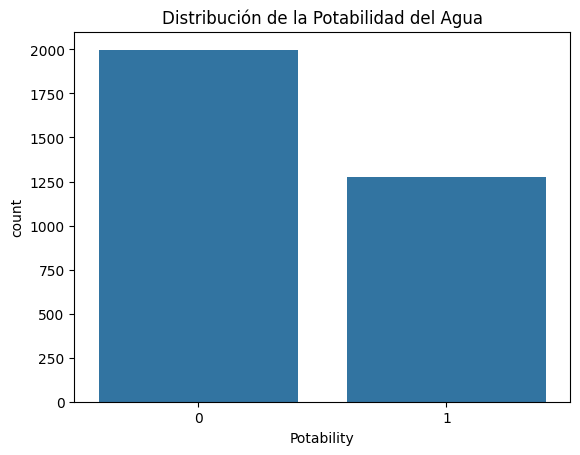

In [3]:
# 🔍 Exploración y preprocesamiento
df.isnull().sum()
df.fillna(df.median(), inplace=True)
sns.countplot(x='Potability', data=df)
plt.title('Distribución de la Potabilidad del Agua')
plt.show()

In [4]:
# 📊 División del conjunto de datos
X = df.drop('Potability', axis=1)
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 🧠 Entrenamiento del modelo CatBoost
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.88      0.78       412
           1       0.63      0.34      0.44       244

    accuracy                           0.68       656
   macro avg       0.66      0.61      0.61       656
weighted avg       0.67      0.68      0.65       656



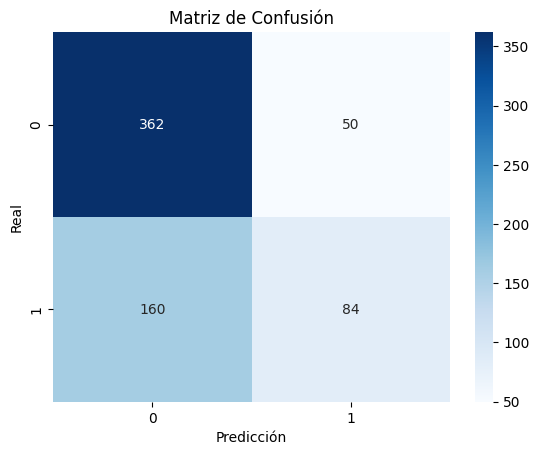

In [ ]:
# --- PASO 0: Importar Librerías ---
# No se incluye !pip install, asumiendo que las librerías ya están en el entorno.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier

# --- Librerías para Preprocesamiento Avanzado ---
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE # Para balanceo avanzado
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline que maneja SMOTE

import warnings

# Configuración
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="darkgrid")
print("Librerías importadas.")

# ---------------------------------------------------------------------------
# --- PASO 1: Entender las columnas del archivo CSV ---
# ---------------------------------------------------------------------------
print("\n--- 1. Cargando y Explorando los Datos ---")
try:
    df = pd.read_csv('data/water_potability.csv')
    print("Archivo 'data/water_potability.csv' cargado exitosamente.")
except FileNotFoundError:
    print("ERROR: 'data/water_potability.csv' no encontrado.")
    print("Asegúrate de que el archivo esté en la ruta correcta antes de continuar.")
    raise SystemExit("Deteniendo ejecución: archivo no encontrado.")

print("\n--- Información General (Tipos de Dato y Conteo) ---")
df.info()

print("\n--- Conteo de Valores Nulos (Missing) ---")
print(df.isna().sum())

print("\n--- Desbalance de Clases (Objetivo 'Potability') ---")
print(df['Potability'].value_counts(normalize=True))

# ---------------------------------------------------------------------------
# --- PASO 2: Selección de Características (Método Embebido) ---
# ---------------------------------------------------------------------------
print("\n--- 2. Implementando Selección de Características (Método Embebido) ---")

# 2a. Preparar datos para el modelo selector
print("Preparando datos para el modelo selector...")
X = df.drop('Potability', axis=1)
y = df['Potability']
feature_names = X.columns # Guardar nombres para después

# 2b. Dividir en Train y Test (CRUCIAL: hacer esto ANTES de cualquier preprocesamiento)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

# 2c. Pipeline de Preprocesamiento Avanzado
# 1. KNNImputer (Imputación avanzada)
# 2. PowerTransformer (Transformación a distribución normal y Estandarización)
print("Creando pipeline de preprocesamiento (Impute -> Transform/Standardize)...")
preprocessing_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Ajustar (fit) el pipeline SÓLO con datos de train (evita data leakage)
print("Ajustando pipeline de preprocesamiento SÓLO en datos de train...")
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
# Transformar el set de prueba
X_test_processed = preprocessing_pipeline.transform(X_test)

# Convertir de nuevo a DataFrames
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

# 2d. Balanceo de Clases Avanzado (SMOTE)
# Se aplica SÓLO al set de entrenamiento
print("Aplicando balanceo de clases (SMOTE) al set de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
print(f"Tamaño de Train antes de SMOTE: {X_train_processed.shape[0]}")
print(f"Tamaño de Train después de SMOTE: {X_train_balanced.shape[0]}")

# 2e. Entrenar modelo "Selector" para obtener importancias
# (Este modelo se entrena con los datos preprocesados, balanceados y TODAS las características)
print("\nEntrenando modelo selector para obtener importancias...")
selector_model = CatBoostClassifier(
    iterations=500, learning_rate=0.05, eval_metric='Accuracy',
    random_seed=42, verbose=0,
    allow_writing_files=False # Evitar archivos de log
)

# Usamos los datos balanceados para el entrenamiento del selector
selector_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=(X_test_processed, y_test),
    early_stopping_rounds=50
)

# 2f. Obtener y mostrar resultados de importancia
print("\n--- Resultados de Importancia de Características (Método Embebido) ---")
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': selector_model.get_feature_importance()
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.to_string())

# 2g. Decisión: Nos quedamos con las 5 características principales
# (Basado en la imagen 'image_fb9c0a.png', las 5 primeras tienen > 10% de importancia)
features_to_keep = importance_df.head(5)['Feature'].tolist()
print(f"\nACCIÓN: Se seleccionan las 5 mejores características: {features_to_keep}")

# ---------------------------------------------------------------------------
# --- PASO 3: Optimización y Entrenamiento del Modelo FINAL ---
# ---------------------------------------------------------------------------
print("\n--- 3. Optimizando y Entrenando Modelo FINAL (sobre 5 características) ---")

# 3a. Reducir los DataFrames a las características seleccionadas
X_train_final = X_train_balanced[features_to_keep]
X_test_final = X_test_processed[features_to_keep] # El Test set NO se balancea

# 3b. Definir los parámetros a probar (GridSearchCV)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'iterations': [500, 1000]
}

# 3c. Inicializar el modelo base para el GridSearch
# No usamos 'scale_pos_weight' porque ya balanceamos con SMOTE
grid_search_model = CatBoostClassifier(
    random_seed=42,
    eval_metric='F1', # Optimizamos para F1, mejor métrica en desbalance
    verbose=0,
    allow_writing_files=False
)

# 3d. Configurar y ejecutar GridSearchCV
grid_search = GridSearchCV(
    estimator=grid_search_model,
    param_grid=param_grid,
    cv=3, # 3-Fold Cross-Validation
    scoring='f1_weighted', # Usamos F1 ponderado para la búsqueda
    n_jobs=-1 # Usar todos los núcleos de CPU
)

print("Iniciando GridSearchCV (esto puede tardar)...")
# Entrenamos la búsqueda sobre los datos de entrenamiento balanceados y reducidos
grid_search.fit(X_train_final, y_train_balanced)

print(f"Mejores Parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor Score F1 (CV): {grid_search.best_score_:.4f}")

# 3e. Obtener el mejor modelo
best_model = grid_search.best_estimator_

# 3f. Evaluación e Interpretación del Modelo Final
print("\n--- Evaluación del Modelo FINAL Optimizado ---")
# Predecimos sobre el X_test_final (reducido, pero no balanceado)
y_pred_final = best_model.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred_final)
print(f"Precisión (Accuracy) - Modelo Final: {accuracy * 100:.2f}%")

print("\nReporte de Clasificación - Modelo Final:")
# Reportamos contra el y_test original
print(classification_report(y_test, y_pred_final))

# Imprimir la Matriz de Confusión en texto
cm = confusion_matrix(y_test, y_pred_final)
print("\nMatriz de Confusión - Modelo FINAL:")
print(cm)

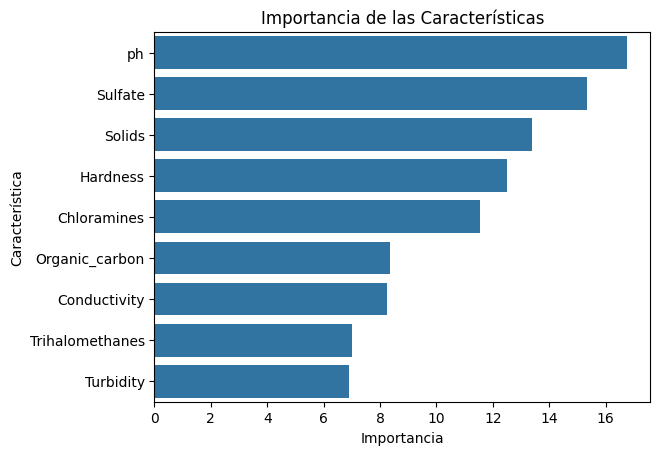

In [7]:
# 📌 Importancia de características
feature_importances = model.get_feature_importance()
features = X.columns
importance_df = pd.DataFrame({'Característica': features, 'Importancia': feature_importances})
importance_df.sort_values(by='Importancia', ascending=False, inplace=True)
sns.barplot(x='Importancia', y='Característica', data=importance_df)
plt.title('Importancia de las Características')
plt.show()